In [6]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import nltk
import spacy
import umap
import string

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [2]:
df = pd.read_csv('octopus_energy_tweets.csv')
df.head()

,Unnamed: 0,tweet
0,0,@octopus_energy I think your wheel is broken 🤣...
1,1,Our 3 stories of the week...\n\nNo 3: Kind cou...
2,2,@adamtranter Glad I jumped ship ages ago. Hope...
3,3,@newelland @octopus_energy I get that HRM is u...
4,4,@newelland @octopus_energy I've also wondered ...


In [4]:
df.tweet.replace("\S*http\S*" , "", regex=True, inplace = True)
df.tweet.replace("_" , " ", regex=True, inplace = True)
df.tweet.replace("^" , " ", regex=True, inplace = True)

In [7]:
for i in string.punctuation:
    try:
        df.tweet.replace(f"\{i}" , "", regex=True, inplace = True)
    except: pass

In [8]:
df.tweet.head()

0     octopus energy I think your wheel is broken 🤣...
1     Our 3 stories of the week\n\nNo 3 Kind couple...
2     adamtranter Glad I jumped ship ages ago Hopef...
3     newelland octopus energy I get that HRM is us...
4     newelland octopus energy Ive also wondered th...
Name: tweet, dtype: object

In [9]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [10]:
def word_root(text):
    list_data3=[]
    text = remove_unicode(text)
    doc = spaci(text)
    for token in doc:
        if token.text.isalpha():
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.tweet = df.tweet.apply(lambda x: word_root(str(x).lower()))  

In [11]:
df.tweet[0]

'octopus energy I think your wheel be break l it hit and roll back I never know do my bill could be so fun if anyone want a referral link hola at I octopussy be a massive improvement on the cowboy I ve be deal with'

In [12]:
df_clean = df.tweet
df_clean.shape

(500,)

In [13]:
df_clean = df_clean.dropna()
df_clean.shape

(500,)

In [14]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [15]:
from sentence_transformers import SentenceTransformer

In [16]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [17]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [18]:
# embeddings1[embeddings1.argmax()]

In [19]:
model2=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings2 = model2.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [20]:
model=SentenceTransformer('roberta-large-nli-stsb-mean-tokens')
embeddings3 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [21]:
model=SentenceTransformer('allenai-specter')
embeddings4 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

In [22]:
UMAP_bert1 = umap.UMAP(n_components=5).fit_transform(embeddings1)

UMAP_bert2 = umap.UMAP(n_components=5).fit_transform(embeddings2)

UMAP_bert3 = umap.UMAP(n_components=5).fit_transform(embeddings3)

UMAP_bert4 = umap.UMAP(n_components=5).fit_transform(embeddings4)

#n_neighbors=10, min_dist=0.0, 

In [23]:
from pyclustertend import hopkins

embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert2" : UMAP_bert2,
              "UMAP_bert3" : UMAP_bert3, "UMAP_bert4" : UMAP_bert4}
              
embeds = {}

for key, emb in embeddings.items():
    embeds[key] = hopkins(emb,emb.shape[0])

embeds
# embeddings[embeds.index(min(embeds))]
# print(f"the hopkins score for embeddings {i} is : {hs}")

{'UMAP_bert1': 0.16374946025431847,
 'UMAP_bert2': 0.1443642761473985,
 'UMAP_bert3': 0.16541037312809387,
 'UMAP_bert4': 0.13141221588734606}

In [57]:
best_embed_name = min(embeds, key=embeds.get)
best_embed_name = 'UMAP_bert2'
best_model = embeddings[best_embed_name]
best_embed_name

'UMAP_bert2'

In [58]:
# #inertia

# kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
#                 for k in range(1, 10)]
# inertias = [model.inertia_ for model in kmeans_per_k]

# plt.plot(range(1, 10), inertias, "bo-")
# plt.xlabel("$k$", fontsize=14)
# plt.ylabel("Inertia", fontsize=14)
# plt.show()

In [65]:
cluster = KMeans(n_clusters=3).fit_predict(best_model)

In [66]:
def plot(cluster = cluster):    
    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings2)
    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))
    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='Accent')
    plt.show()

{0: 191, 1: 127, 2: 182}


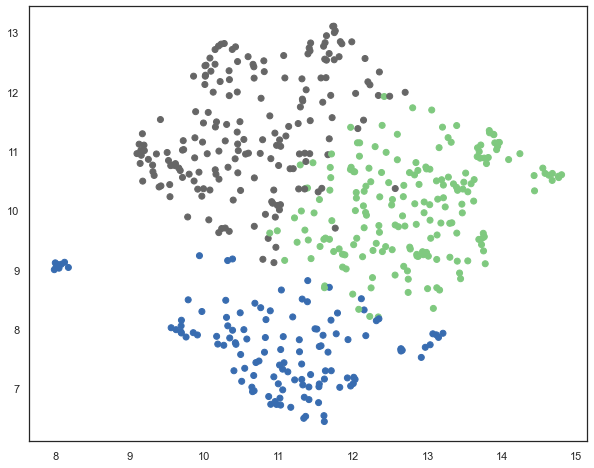

In [67]:
plot()

In [68]:
docs = pd.DataFrame(df_clean)
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"tweet": " ".join})
labeled_docs.tweet.replace(r"\S*octo\S*", "octopus", regex=True, inplace = True)
labeled_docs.tweet.replace(r"\S*octu\S*", "octopus", regex=True, inplace = True)
labeled_docs.tweet.replace(r"\S*wind\S*", "wind", regex=True, inplace = True)
labeled_docs.tweet.replace(r"\S*electr\S*", "electric", regex=True, inplace = True)
labeled_docs.tweet.replace(r"\S*energ\S*", "energy", regex=True, inplace = True)
labeled_docs

,cluster,tweet
0,0,octopus energy I think your wheel be break l i...
1,1,newelland octopus energy I get that hrm be use...
2,2,our story of the weekno kind couple help deliv...


In [71]:
from keybert import KeyBERT
array_text = labeled_docs.tweet.tolist()

model_names = {"model1":'distilbert-base-nli-mean-tokens',
               "model2": "xlm-r-distilroberta-base-paraphrase-v1" ,
               "model3": 'roberta-large-nli-stsb-mean-tokens',
               "model4": "allenai-specter"}
    
print("-"*20,best_embed_name,"-"*20)
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
unigram = []
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,stop_words=["twitter"],)
    if not keywords:
        k -= 1
    else:
        unigram.append([word[0] for word in keywords])

-------------------- UMAP_bert2 --------------------


In [72]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
bigram = []
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,keyphrase_ngram_range=(1, 2))
    if not keywords:
        k -= 1
    else:

        bigram.append([word[0] for word in keywords])

In [73]:
kw_extractor = KeyBERT('xlm-r-distilroberta-base-paraphrase-v1')
k = 0
trigram = []
for j in range(len(array_text)):
    k+=1
    keywords = kw_extractor.extract_keywords(array_text[j],top_n=10,keyphrase_ngram_range=(1, 3))
    if not keywords:
        k -= 1
    else:
        trigram.append([word[0] for word in keywords])

In [74]:
unigram

[['octopus',
  'excellent',
  'poop',
  'fantastic',
  'apple',
  'oopsi',
  'thanksfor',
  'gop',
  'wonderful',
  'great'],
 ['organizational',
  'organisational',
  'octopus',
  'departmenthrhumanresourcesemployeerelationscipd',
  'employer',
  'obsess',
  'employee',
  'staff',
  'corporate',
  'industrial'],
 ['octopus',
  'tuesday',
  'hourly',
  'timetable',
  'cto',
  'hour',
  'edf',
  'weekno',
  'poss',
  'eddisonj']]

In [75]:
bigram

[['octopus great',
  'excellent octopus',
  'worldofgoodbook octopus',
  'great octopus',
  'happy octopus',
  'wonderful octopus',
  'jcbe octopus',
  'thank octopus',
  'octopus outstanding',
  'fantastic octopus'],
 ['job octopus',
  'work octopus',
  'leadership octopus',
  'efficiency octopus',
  'especially employee',
  'octopus manufacture',
  'like organisational',
  'departmenthrhumanresourcesemployeerelationscipd robacareerpsych',
  'use octopus',
  'run octopus'],
 ['supply octopus',
  'email octopus',
  'octopus app',
  'hour octopus',
  'issue octopus',
  'octopus team',
  'octopus energy',
  'work octopus',
  'energy octopus',
  'company octopus']]

In [76]:
trigram

[['octopus energy great',
  'octopus energy good',
  'octopus great',
  'good thing octopus',
  'great company octopus',
  'merge octopus great',
  'octopus energy nice',
  'great thank octopus',
  'octopus energy fantastic',
  'excellent octopus energy'],
 ['company work octopus',
  'businessandmanagement leadership octopus',
  'job octopus energy',
  'management leadership octopus',
  'organizational design octopus',
  'job octopus',
  'company hr octopus',
  'work octopus energy',
  'work octopus',
  'work octopus really'],
 ['octopus energy thank',
  'octopus energy wait',
  'octopus energy fix',
  'octopus energy timetable',
  'octopus energy week',
  'octopus energy update',
  'issue octopus energy',
  'octopus energy try',
  'octopus energy email',
  'energy company octopus']]

In [79]:
for i in range(3):
    print("Cluster", str(i+1)," :")
    print(trigram[i][0:2]+bigram[i][0:2]+unigram[i])

Cluster 1  :
['octopus energy great', 'octopus energy good', 'octopus great', 'excellent octopus', 'octopus', 'excellent', 'poop', 'fantastic', 'apple', 'oopsi', 'thanksfor', 'gop', 'wonderful', 'great']
Cluster 2  :
['company work octopus', 'businessandmanagement leadership octopus', 'job octopus', 'work octopus', 'organizational', 'organisational', 'octopus', 'departmenthrhumanresourcesemployeerelationscipd', 'employer', 'obsess', 'employee', 'staff', 'corporate', 'industrial']
Cluster 3  :
['octopus energy thank', 'octopus energy wait', 'supply octopus', 'email octopus', 'octopus', 'tuesday', 'hourly', 'timetable', 'cto', 'hour', 'edf', 'weekno', 'poss', 'eddisonj']
